In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.utils import shuffle
from algs_lib import *
from math import comb

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times']})
# plt.rcParams["font.family"] = "Helvetica"

rc('text', usetex=True)

In [2]:
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

In [3]:
def load_svm(reg, noise, iso=False):
    mi_range = [1/128., 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0]
    x_vals = []
    y_vals = []
    for mi in mi_range:
        fname = f"hybrid_lr/iris_svm_C={reg}_mi={mi}_noise={noise}.pkl"
        if iso:
            fname = f"hybrid_lr/iris_svm_iso_C={reg}_mi={mi}_noise={noise}.pkl"
        combined = pickle.load(open(fname, 'rb'))
        accs = []
        for r in combined:
            if 100*r % 5 != 0:
                continue
            accs.append(combined[r][0]*0.5 + 0.5*(1-combined[r][1]))
        x_vals.append(np.log2(mi))
        y_vals.append(100*(max(accs) - 0.5))
    return x_vals, y_vals

def load_kmeans(noise, iso=False):
    mi_range = [1/128., 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0]
    x_vals = []
    y_vals = []
    for mi in mi_range:
        fname = f"hybrid_lr/iris_kmeans_mi={mi}_noise={noise}.pkl"
        if iso:
            fname = f"hybrid_lr/iris_kmeans_iso_mi={mi}_noise={noise}.pkl"
        combined = pickle.load(open(fname, 'rb'))
        accs = []
        for r in combined:
            if 100*r % 5 != 0:
                continue
            accs.append(combined[r][0]*0.5 + 0.5*(1-combined[r][1]))
#         print(mi, max(accs))
        x_vals.append(np.log2(mi))
        y_vals.append(100*(max(accs) - 0.5))
    return x_vals, y_vals

----
Iris K-Means
[8.400850000000004, 10.099900000000005, 9.6507, 7.952950000000003, 9.605299999999994, 8.257500000000007, 9.007699999999996, 9.309500000000003, 8.557950000000003]
8.982483333333334
[2.1500000000000075, 1.9000000000000017, 1.9000000000000017, 3.400000000000003, 6.45, 9.650000000000002, 9.600000000000009, 9.499999999999996, 8.949999999999992]
5.944444444444446
[1.0499999999999954, 1.4499999999999957, 1.4000000000000012, 3.299999999999992, 4.800000000000004, 6.950000000000001, 8.450000000000003, 9.399999999999997, 8.350000000000001]
5.016666666666666
------
----
Iris SVM (C=1.0)
[4.7040032029516565, 3.4015027511012486, 4.60220310255286, 4.353654001952756, 5.603454353654003, 3.202055602153453, 4.799853151305255, 2.9535046521025454, 5.403152953504653]
4.335931530142047
[1.1502000000000012, 2.8998999999999997, 1.7000007999500077, 1.3489494992511952, 1.150598450351148, 0.9010991505999044, 1.902249952600199, 3.352600703349451, 2.3542003530001576]
1.862199878789118
[2.151550000

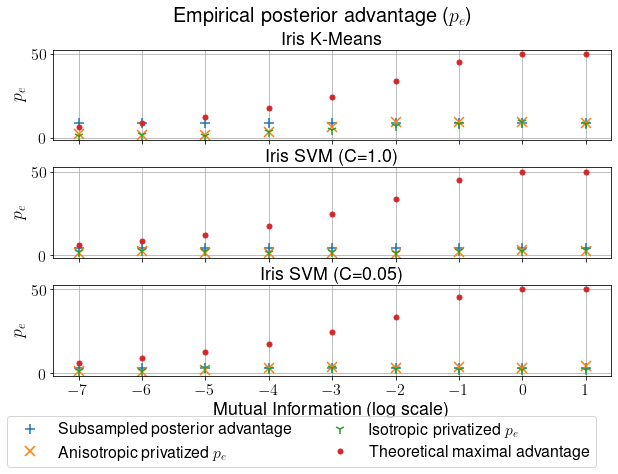

In [5]:

titles = ["Iris K-Means", "Iris SVM (C=1.0)", "Iris SVM (C=0.05)"]
fig, axes = plt.subplots(3, sharex=True, figsize=(10, 6))
fns = [load_kmeans, load_svm, load_svm]

for ind, title in enumerate(titles):
    ax = axes[ind]
#     if ind == 0 or ind == 2:
#         continue
    if ind == 0:
        x_vals, orig_y_vals = load_kmeans(False)
        x_vals, priv_y_vals = load_kmeans(True)
        x_vals, iso_priv_y_vals = load_kmeans(True, True)
    elif ind == 1:
#         print('orig')
        x_vals, orig_y_vals = load_svm(1.0, False)
#         print('priv')
        x_vals, priv_y_vals = load_svm(1.0, True)
#         print('iso priv')
        x_vals, iso_priv_y_vals = load_svm(1.0, True, True)
    else:
        x_vals, orig_y_vals = load_svm(0.05, False)
        x_vals, priv_y_vals = load_svm(0.05, True)
        x_vals, iso_priv_y_vals = load_svm(0.05, True, True)
    print('----')
    print(titles[ind])
    print(orig_y_vals)
    print(np.average(orig_y_vals))
    print(priv_y_vals)
    print(np.average(priv_y_vals))
    print(iso_priv_y_vals)
    print(np.average(iso_priv_y_vals))
    print('------')
    theoretical_bound = [100*(calc_posterior(2**x) - 0.5) for x in x_vals]
#     print(theoretical_bound)
    ax.plot(x_vals, [np.average(orig_y_vals)]*len(orig_y_vals), '+', markersize=10, mew=1.5, label="Subsampled posterior advantage")
    ax.plot(x_vals, priv_y_vals, 'x', markersize=10, mew=1.5, label="Anisotropic privatized $p_e$")
#     print(orig_y_vals, priv_y_vals)
    ax.plot(x_vals, iso_priv_y_vals, '1', markersize=10, mew=1.5, label="Isotropic privatized $p_e$")
    ax.plot(x_vals, theoretical_bound, 'o', markersize=5, label="Theoretical maximal advantage")


    ax.set_ylabel("$p_e$", fontsize=18)
    ax.set_title(titles[ind], fontsize=18)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=16)
plt.subplots_adjust(hspace=0.3)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, ncol=2, loc=2, prop={'size': 16}, bbox_to_anchor=(0.05, 0.05))
plt.xlabel("Mutual Information (log scale)", fontsize=18)
plt.suptitle(f"Empirical posterior advantage ($p_e$)", fontsize=20)
plt.savefig('hybrid_figs/empirical_posterior_adv.png', bbox_inches = "tight")

In [31]:
np.average([1.4020000000000032, 2.8005009005000026, 4.499901801050243, 3.2004018497527986, 4.002302149253056, 4.5518540023021465, 3.402853551753604, 3.453502351904003, 1.6017516510013041])

3.212785361946351

In [40]:
3.17-2.7

0.46999999999999975

In [39]:
2.95-2.5

0.4500000000000002